In [1]:
import sys
import os
from Args import get_notebook_args, Args
sys.path.insert(0, os.path.abspath('../..'))
from src.DataLoad import load_source_data
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from src.Epoch import train_epoch
from src.utility import precompute_gaussian_params
from src.Neural import CNF, RunningAverageMeter
from src.plot import *
from src.PreProcess import *
from src.DataLoad import *

2025-07-25 12:00:42.761971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 12:00:43.467398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.1/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu:/home/jfwang/local/gsl-install/lib:/usr/local/cuda/lib64:/home/jfwang/.local/lib/python3.10/site-packages/nvidia/cudnn/lib
2025-07-25 12:00:43.467534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [2]:
def plot_embeddings(
    data_list, 
    time_labels=None, 
    colors=None, 
    figsize=(15, 20), 
    alpha=0.5, 
    title="Temporal Embedding Visualization", 
    marker='o', 
    s=30, 
    TwoDplot=True
):
    """
    Plot the temporal embeddings of the data in 2D or 3D.

    Parameters:
        data_list: list of tensors or arrays, each contains the data of a time point
        time_labels: optional, list of time point labels, default is 't0, t1, t2...'
        colors: optional, list of colors, default is the color cycle of matplotlib
        figsize: figure size, default (15, 20)
        alpha: point opacity, default 0.5
        title: figure title, default "Temporal Embedding Visualization"
        marker: scatter plot marker, default 'o'
        s: point size, default 30
        TwoDplot: if True, plot 2D; if False, plot 3D
    Returns:
        fig, ax: matplotlib figure and axis object, can be further customized
    """
    # Check the dimension of the data
    for i, data in enumerate(data_list):
        if TwoDplot:
            if data.shape[1] < 2:
                print(f" Warning: The dataset {i} is not two-dimensional. Shape: {data.shape}")
        else:
            if data.shape[1] < 3:
                print(f" Warning: The dataset {i} is not three-dimensional. Shape: {data.shape}")
    # Select the first 2 or 3 dimensions for plotting
    if TwoDplot:
        data_plot = [data[:, [1, 2]] for data in data_list]
    else:
        data_plot = [data[:, :3] for data in data_list]

    # Create default labels if not provided
    if time_labels is None:
        time_labels = [f't{i}' for i in range(len(data_list))]

    # Create default colors list if not provided
    if colors is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        if len(colors) < len(data_list):
            colors = list(mcolors.TABLEAU_COLORS.values()) * ((len(data_list) // len(mcolors.TABLEAU_COLORS)) + 1)
            colors = colors[:len(data_list)]

    # Create the figure and axis
    if TwoDplot:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')

    # Plot the data for each time point
    for i, data in enumerate(data_plot):
        color_idx = i % len(colors)  # Cycle through colors if not enough
        data_np = data.detach().cpu().numpy() if hasattr(data, 'detach') else data
        if TwoDplot:
            ax.scatter(data_np[:, 0], data_np[:, 1], 
                       color=colors[color_idx], 
                       alpha=alpha, 
                       label=time_labels[i],
                       marker=marker,
                       s=s)
        else:
            ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2],
                       color=colors[color_idx], 
                       alpha=alpha, 
                       label=time_labels[i],
                       marker=marker,
                       s=s)

    # Add legend and labels
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    if not TwoDplot:
        ax.set_zlabel("Dimension 3", fontsize=12)
        ax.set_box_aspect([1,1,1])  # Keep xyz aspect ratio equal
        # Optionally, you can set the view angle:
        # ax.view_init(elev=20, azim=120)
    else:
        ax.set_aspect('equal')

    return fig, ax

Default data path: ../../data/scMultiSim/all_time_scRNA_pca.npz
Default time labels: ['time1', 'time2', 'time3', 'time4']
Default ot dimension: 5
Default time points: [1, 2, 3, 4]
Data type: <class 'numpy.lib.npyio.NpzFile'>
Available keys in npz file: ['time1', 'time2', 'time3', 'time4']


time point time1 data shape: torch.Size([2006, 5])
time point time2 data shape: torch.Size([2001, 5])
time point time3 data shape: torch.Size([3008, 5])
time point time4 data shape: torch.Size([2985, 5])


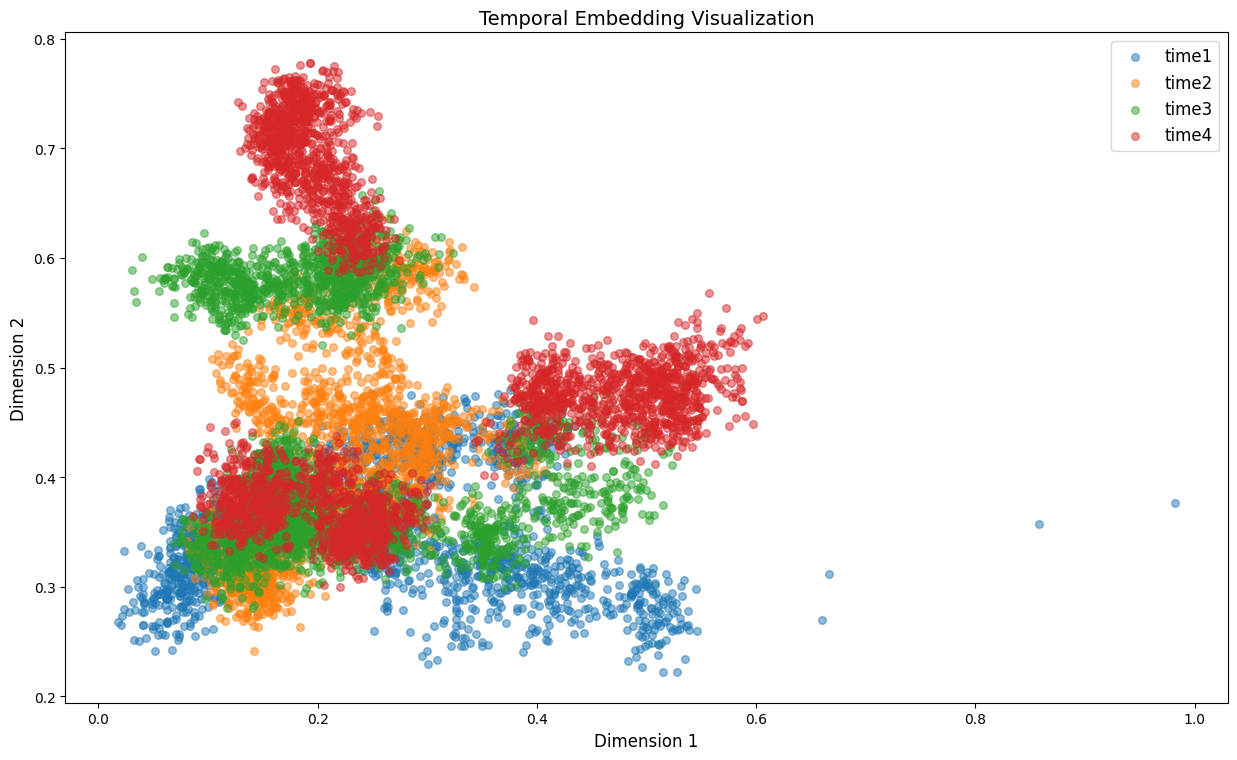

In [3]:
args = get_notebook_args()
print(f"Default data path: {args.data_path}")
print(f"Default time labels: {args.time_labels}")
print(f"Default ot dimension: {args.otdim}")
print(f"Default time points: {args.time_points}")
data_train= load_source_data(args.data_path, args.time_labels, args.support_points)


device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() and args.gpu >= 0 else 'cpu')
primary_data = [data for data in data_train] 

# record the number of samples in each group
lengths = [data.shape[0] for data in primary_data]

# concatenate and normaliz


total_primal = torch.cat(primary_data, dim=0)
total_primal, norm_params = normalize_to_unit_cube(total_primal, save_path='primal_norm_params.pt')

# split back according to the recorded lengths
split_points = torch.cumsum(torch.tensor(lengths), dim=0).tolist()
start = 0
normalized_data = []

for end in split_points:
    normalized_data.append(total_primal[start:end])
    start = end

# update primary_data to the normalized data
primary_data = normalized_data 
time_labels = args.time_labels

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() and args.gpu >= 0 else 'cpu')

fig, ax = plot_embeddings(primary_data, args.time_labels)
plt.show()

In [4]:



density_precompute_list = []
for i in range(len(args.time_points)):
    z_curr_primal = primary_data[i]
    sigma = args.sigma
    weights, means, precisions = precompute_gaussian_params(z_curr_primal, sigma, device)
    density_precompute_list.append((weights, means, precisions))
    
time_steps_list = []
for t_idx in range(len(args.time_points) - 1):
    dt = args.dt
    t0, t1 = args.time_points[t_idx], args.time_points[t_idx + 1]
    
    time_steps_short_backward = torch.linspace(t1, t0, int((t1-t0)/dt)+1).to(device)
    time_steps_short_forward = torch.linspace(t0, t1, int((t1-t0)/dt)+1).to(device)
    
    t_init = args.time_points[0]
    time_steps_long_backward = torch.linspace(t1, t_init, int((t1-t_init)/dt)+1).to(device)
    time_steps_long_forward = torch.linspace(t_init, t1, int((t1-t_init)/dt)+1).to(device)
    
    time_steps_list.append((time_steps_short_backward, time_steps_short_forward, 
                            time_steps_long_backward, time_steps_long_forward))
print(time_steps_list)

func = CNF(in_out_dim=args.otdim, hidden_dim=args.hidden_dim, n_hiddens=args.n_hiddens,activation=args.activation).to(device)
#optimizer = optim.Adam(func.parameters(), lr=args.lr)
optimizer = optim.AdamW(
func.parameters(),
lr=args.lr,
weight_decay=0.001
)

total_steps = args.niters
gamma = (5e-6 / args.lr) ** (2.0 / total_steps) 

loss_meter = RunningAverageMeter()

scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=gamma,
    verbose=True
)


from src.utility import load_checkpoint
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from collections import deque
from functools import partial
from torchdiffeq import odeint
from src.DataLoad import get_exact_batch
from src.MapSpace import map_to_nearest_manifold
from PIL import Image
import glob
from collections import deque
from src.Loss import Manifold_reconstruction_loss
    
load_checkpoint(func, optimizer, scheduler, args, ckpt_path='ckpt_iter_3000.pth')

[(tensor([2.0000, 1.9500, 1.9000, 1.8500, 1.8000, 1.7500, 1.7000, 1.6500, 1.6000,
        1.5500, 1.5000, 1.4500, 1.4000, 1.3500, 1.3000, 1.2500, 1.2000, 1.1500,
        1.1000, 1.0500, 1.0000], device='cuda:0'), tensor([1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000,
        1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500,
        1.9000, 1.9500, 2.0000], device='cuda:0'), tensor([2.0000, 1.9500, 1.9000, 1.8500, 1.8000, 1.7500, 1.7000, 1.6500, 1.6000,
        1.5500, 1.5000, 1.4500, 1.4000, 1.3500, 1.3000, 1.2500, 1.2000, 1.1500,
        1.1000, 1.0500, 1.0000], device='cuda:0'), tensor([1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000,
        1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500,
        1.9000, 1.9500, 2.0000], device='cuda:0')), (tensor([3.0000, 2.9500, 2.9000, 2.8500, 2.8000, 2.7500, 2.7000, 2.6500, 2.6000,
        2.5500, 2.5000, 2.4500, 2.4000, 2.3500, 2.3000, 2.2500, 2.2000, 

/home/jfwang/miniconda3/envs/SynOT/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/media/hdd/jfwang/sOT/TraInf/src/utility.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wh

3000

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def Jacobian(f, z):
    """Calculates Jacobian df/dz.
    """
    jac = []
    for i in range(z.shape[1]):
        df_dz = torch.autograd.grad(f[:, i], z, torch.ones_like(f[:, i]),retain_graph=True, create_graph=True)[0].view(z.shape[0], -1)
        jac.append(torch.unsqueeze(df_dz, 1))
    jac = torch.cat(jac, 1)
    return jac

def compute_velocity_jacobian(h, NN1, z, t):
    """
    Computes ∂(h(z + NN1(z, t)) - h(z)) / ∂z
    
    h: decoder (e.g., PCA inverse)
    NN1: velocity predictor in latent space
    z: latent code (requires grad)
    t: time (if applicable to NN1)
    """
    z = z.clone().detach().requires_grad_(True)
    v_latent = NN1(z, t)
    f = h(z + v_latent) - h(z)  # shape: (n_gene,)
    
    # Now compute Jacobian: shape (n_gene, latent_dim)
    jac_rows = []
    for i in range(f.shape[0]):
        grad_i = torch.autograd.grad(f[i], z, retain_graph=True, create_graph=True)[0]
        jac_rows.append(grad_i.view(1, -1))  # row vector
    J = torch.cat(jac_rows, dim=0)
    return J

In [6]:

import joblib

norm_params = torch.load('primal_norm_params.pt', map_location='cpu')
print(norm_params)
std = norm_params['std'].squeeze()  # shape: [n_features]
target_std = norm_params['target_std']  # scalar
scale = target_std / (std + 1e-8)  # shape: [n_features]
D = torch.diag(scale)
print(D)

g_xt0 = torch.zeros(1, 1).type(torch.float32).to(device)
logp_diff_xt0 = g_xt0
z_t = data_train[0]
time_points = args.time_points
time_pt = time_points[0]
print("time_pt",time_pt)

grn_list = []
for i in range(len(time_points)):
    z_t = data_train[i]
    time_pt = time_points[i]
    # compute the mean of jacobian of v within cells z_t at time (time_pt)
    dim = z_t.shape[1]
    jac = np.zeros((dim,dim))
    for i in range(z_t.shape[0]):
        x_t = z_t[i,:].reshape([1,dim])
        v_xt = func(torch.tensor(time_pt).type(torch.float32).to(device),(x_t,g_xt0, logp_diff_xt0))[0]
        jac = jac+Jacobian(v_xt, x_t).reshape(dim,dim).detach().cpu().numpy()
    jac = jac/z_t.shape[0]
    print(jac.shape)
    grn_list.append(jac)

grn_mean = np.mean(grn_list, axis=0)
print(grn_mean.shape)

pca_loaded = joblib.load('pca_model_RNA.pkl')
W = pca_loaded.components_.T
print(W.shape)



/home/jfwang/media/jfwang/Cursor/tmp/ipykernel_1392526/571112265.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_params = torch.load('primal_norm_params.pt', map_lo

{'mean': tensor([[-4.1008e-09,  1.0490e-09, -4.7684e-09,  5.7220e-10,  0.0000e+00]]), 'std': tensor([[6.1869, 3.3685, 3.0256, 2.9107, 2.2384]]), 'target_std': 0.12, 'target_center': tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000]), 'shift': tensor([0.5565, 0.2430, 0.4383, 0.5154, 0.4979])}
tensor([[0.0194, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0356, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0397, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0412, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0536]])
time_pt 1


(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(110, 5)


In [7]:
Test =  W.T @ W
print(Test)
# filter the entry larger than 0.01
m = Test > 0.01
print(m)
filter_Test = Test[m]
print(filter_Test)


[[ 1.00000000e+00  1.75968962e-17 -4.57931613e-16 -1.02302830e-16
  -3.17854665e-17]
 [ 1.75968962e-17  1.00000000e+00  5.00863872e-16  1.72631060e-16
   3.79430306e-16]
 [-4.57931613e-16  5.00863872e-16  1.00000000e+00  2.00663930e-16
   1.10267338e-17]
 [-1.02302830e-16  1.72631060e-16  2.00663930e-16  1.00000000e+00
   5.71358530e-16]
 [-3.17854665e-17  3.79430306e-16  1.10267338e-17  5.71358530e-16
   1.00000000e+00]]
[[ True False False False False]
 [False  True False False False]
 [False False  True False False]
 [False False False  True False]
 [False False False False  True]]
[1. 1. 1. 1. 1.]


(110, 110)


/home/jfwang/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jfwang/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


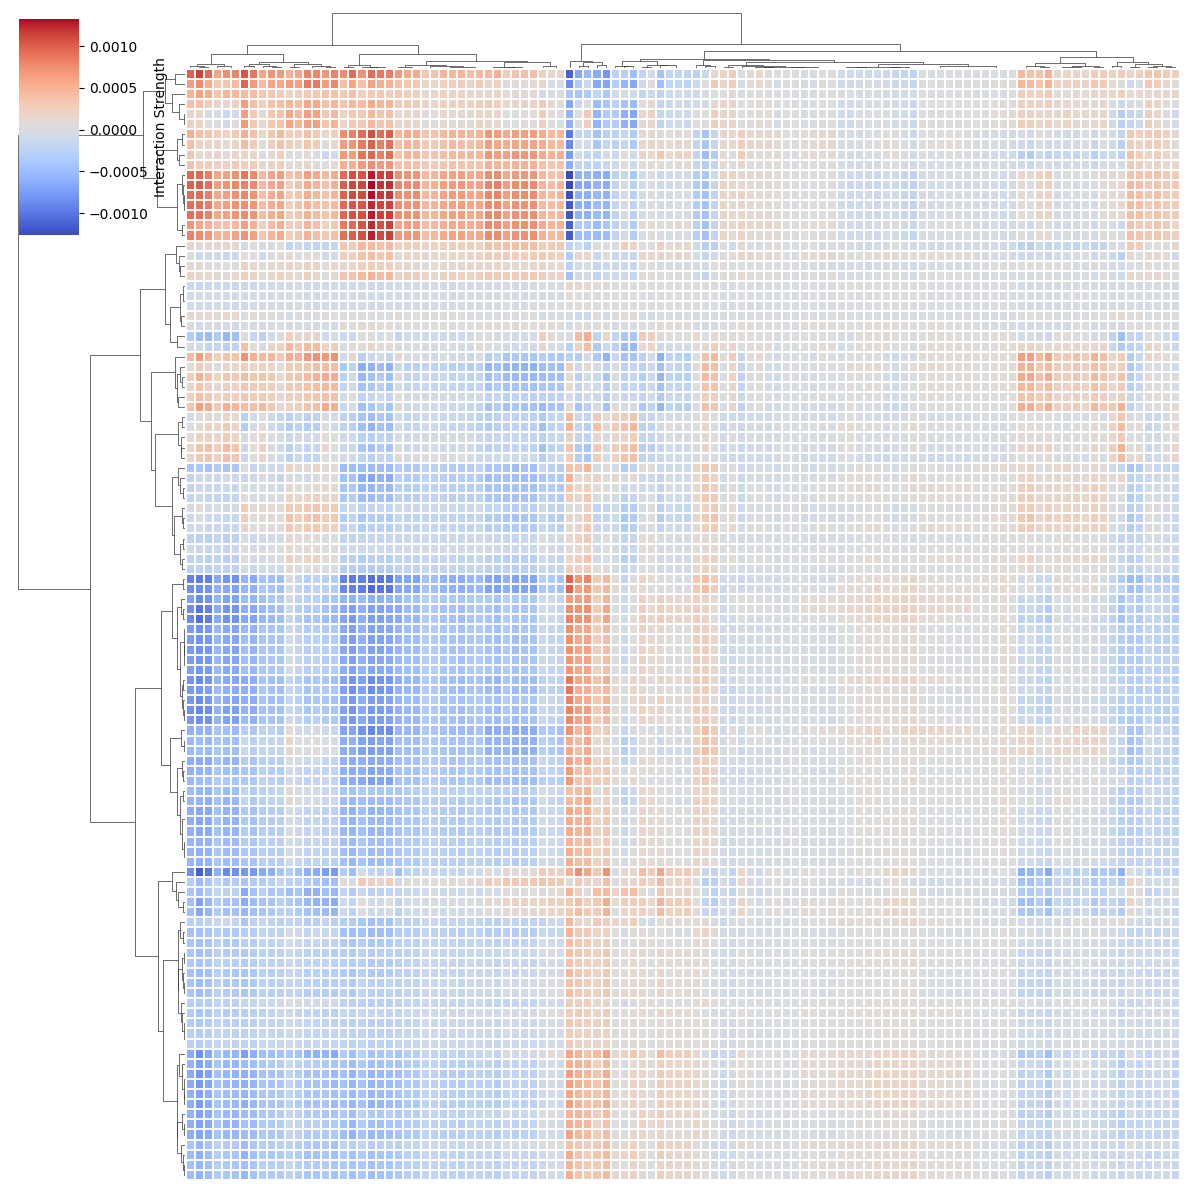

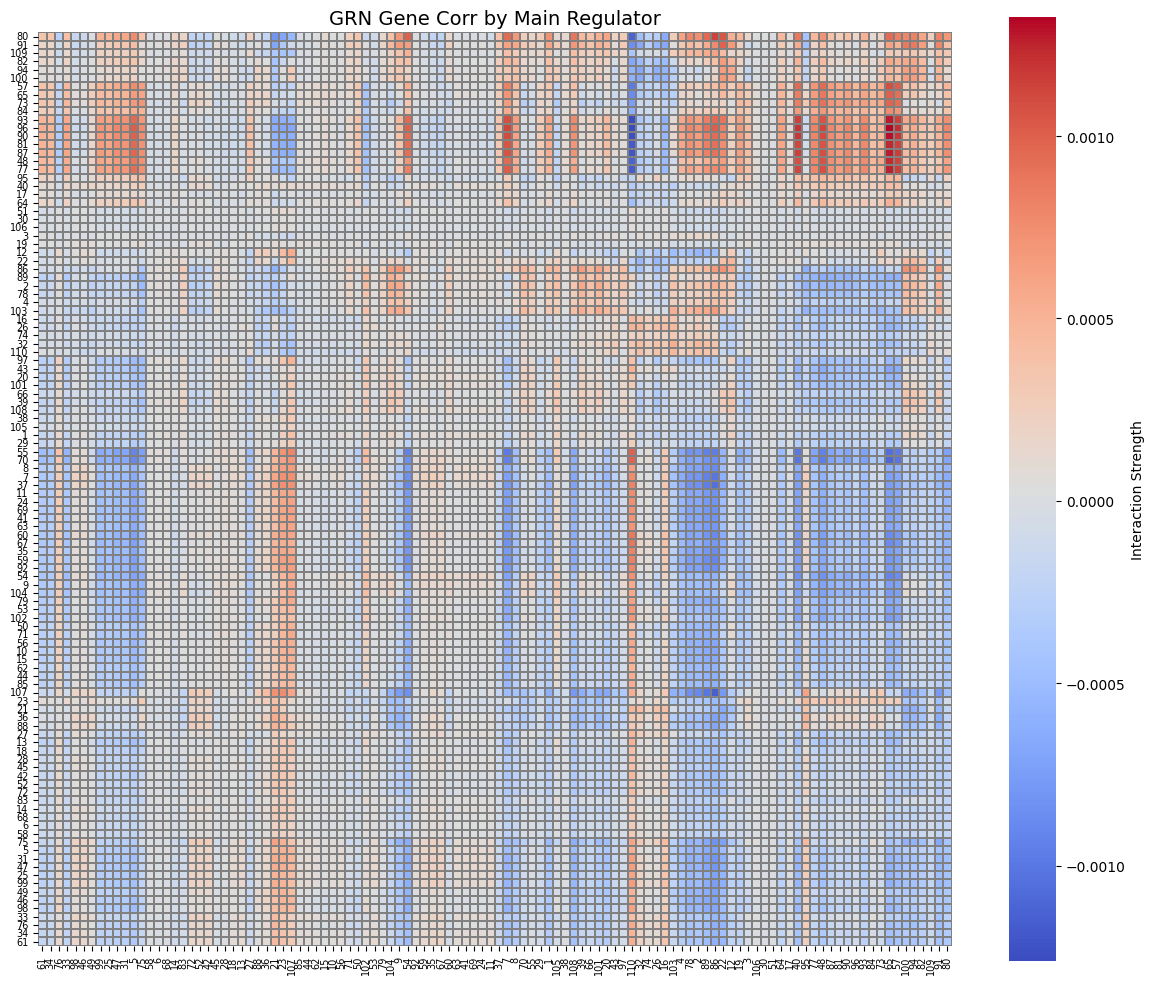

In [8]:
if isinstance(D, torch.Tensor):
    D = D.cpu().numpy()
else:
    D = D

Gene_jac = W @  grn_mean @ D @ W.T 
print(Gene_jac.shape)
gene_labels = [str(i) for i in range(1, Gene_jac.shape[0] + 1)]


# generate the clustermap
g = sns.clustermap(Gene_jac,
                   method='ward',
                   metric='euclidean',
                   cmap='coolwarm',
                   xticklabels=False,  # hide the labels
                   yticklabels=False,
                   figsize=(12, 12),
                   cbar_kws={'label': 'Interaction Strength'},
                   dendrogram_ratio=(.15, .05),
                   linewidths=0.1)

# extract the order of genes
row_order = g.dendrogram_row.reordered_ind

# reorder the matrix
reordered = Gene_jac[np.ix_(row_order, row_order[::-1])]
labels_ordered = [gene_labels[i] for i in row_order]
labels_ordered_rev = labels_ordered[::-1]

# use heatmap to show the matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(reordered,
            cmap="coolwarm",
            xticklabels=labels_ordered_rev,
            yticklabels=labels_ordered,
            cbar_kws={'label': 'Interaction Strength'},
            square=True,
            linewidths=0.1,
            linecolor='gray',
            ax=ax)

# set the font size of the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

# set the title
plt.title("GRN Gene Corr by Main Regulator", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
print(Gene_jac.shape)
print(Gene_jac[63][76])

(110, 110)
0.0003315543867007872


In [10]:
norm_params = torch.load('primal_norm_params.pt', map_location='cpu')
print(norm_params)
std = norm_params['std'].squeeze()  # shape: [n_features]
target_std = norm_params['target_std']  # scalar
scale = target_std / (std + 1e-8)  # shape: [n_features]
D = torch.diag(scale)
print(D)

{'mean': tensor([[-4.1008e-09,  1.0490e-09, -4.7684e-09,  5.7220e-10,  0.0000e+00]]), 'std': tensor([[6.1869, 3.3685, 3.0256, 2.9107, 2.2384]]), 'target_std': 0.12, 'target_center': tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000]), 'shift': tensor([0.5565, 0.2430, 0.4383, 0.5154, 0.4979])}
tensor([[0.0194, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0356, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0397, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0412, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0536]])


/home/jfwang/media/jfwang/Cursor/tmp/ipykernel_1392526/2892155468.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_params = torch.load('primal_norm_params.pt', map_l

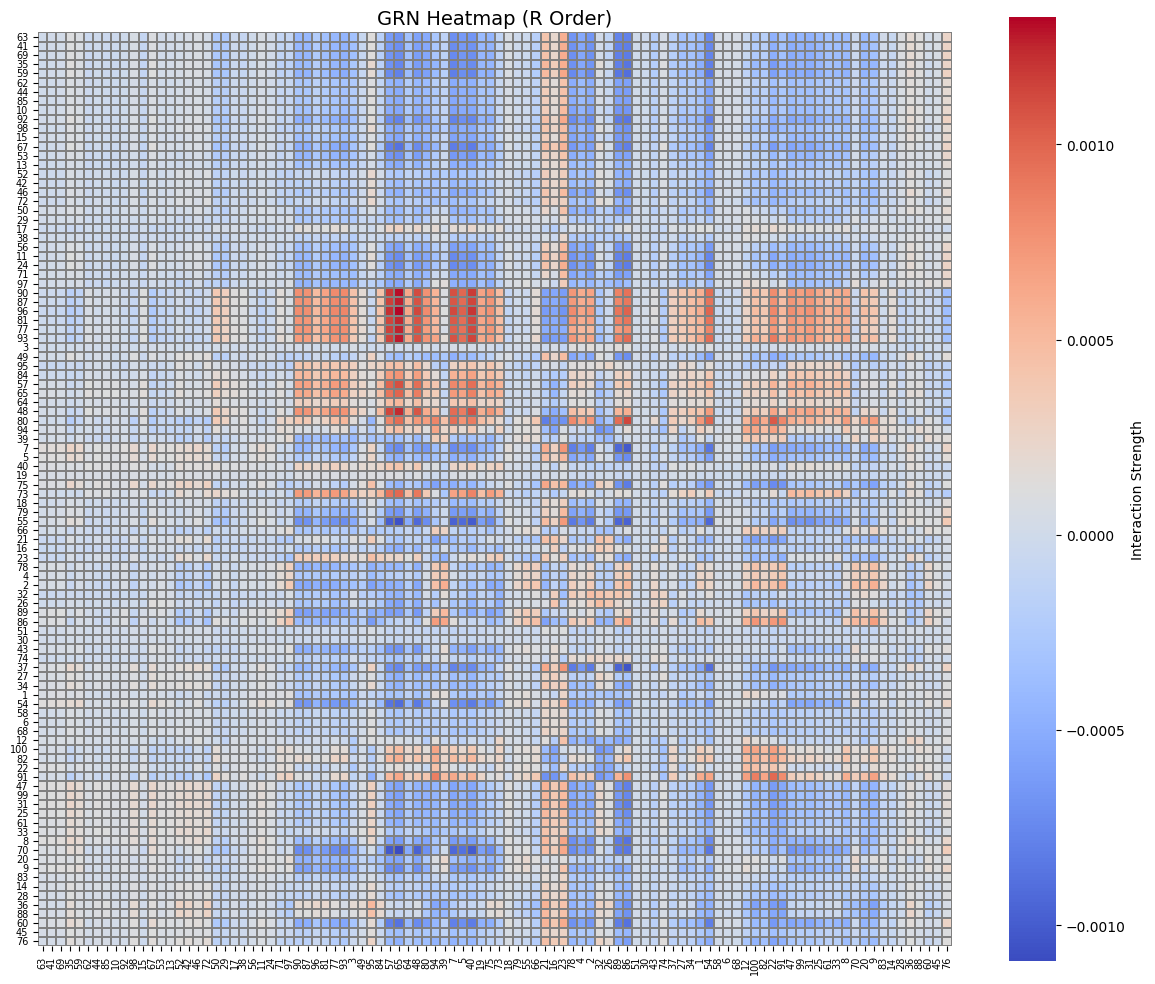

In [11]:
gene_order_r = ["76", "45", "60", "88", "36", "28", "14", "83", "9", "20", "70", "8",
                "33", "61", "25", "31", "99", "47", "91", "22", "82", "100", "12", "68",
                "6", "58", "54", "1", "34", "27", "37", "74", "43", "30", "51", "86",
                "89", "26", "32", "2", "4", "78", "23", "16", "21", "66", "55", "79",
                "18", "73", "75", "19", "40", "5", "7", "39", "94", "80", "48", "64",
                "65", "57", "84", "95", "49", "3", "93", "77", "81", "96", "87", "90",
                "97", "71", "24", "11", "56", "38", "17", "29", "50", "72", "46", "42",
                "52", "13", "53", "67", "15", "98", "92", "10", "85", "44", "62", "59",
                "35", "69", "41", "63"]

gene_labels = [str(i) for i in range(1, Gene_jac.shape[0] + 1)]

# 创建 label -> index 映射
label_to_index = {label: i for i, label in enumerate(gene_labels)}

# 用 R 给出的顺序映射成 Python 中 Gene_jac 的行/列索引
ordered_indices = [label_to_index[label] for label in gene_order_r]

# 列方向反过来（左到右），行方向保留（下到上）
reordered = Gene_jac[np.ix_(ordered_indices, ordered_indices[::-1])]

# 同时准备标签
x_labels = gene_order_r[::-1]  # 左到右
y_labels = gene_order_r        # 下到上

# 画热图
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(reordered,
            cmap="coolwarm",
            xticklabels=x_labels,
            yticklabels=y_labels,
            cbar_kws={'label': 'Interaction Strength'},
            square=True,
            linewidths=0.1,
            linecolor='gray',
            ax=ax)

# 美化字体
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

# 关键：让 y 轴从下往上（与 R 热图一致）
ax.invert_yaxis()

# 标题等
plt.title("GRN Heatmap (R Order)", fontsize=14)
plt.tight_layout()
plt.show()